In [ ]:
import sklearn
sklearn.__version__

In [26]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import statsmodels.api as sm
from typing import List
from scipy.stats import normaltest

In [9]:
seattle_housing = pull_data()

In [112]:
def model(con_var: List[str], cat_var: List[str]) -> None:
    """makes model, gets report, display stats"""
    #seattle_housing = pull_data()
    dep_var, features = build_base(seattle_housing)
    cont = load_con(seattle_housing, con_var)
    cat = make_ohe(seattle_housing, cat_var)
    big_df = combine(features, cont, cat)
    result = ols(dep_var, big_df)
    edited_df = drop_features(result, big_df)
    result_limited = ols(dep_var, edited_df)
    model_eval(result_limited, dep_var, edited_df)
    return result_limited.summary()


In [3]:
def pull_data(dbname = 'Seattle_housing', low_limit = '5000', year = 2018):
    """This function takes data from a postgreSQL database and returns a target dataframe and features dataframe."""
    engine = create_engine(f"postgresql:///{dbname}")
    query = f"""SELECT 
               *
            FROM rpsale rp
            JOIN resbldg rd
            ON CONCAT(rp."Major", rp."Minor") = Concat(rd."Major", rd."Minor")
            JOIN parcel p
            ON CONCAT(rp."Major", rp."Minor") = Concat(p."Major", p."Minor")
            WHERE "SalePrice" > {low_limit}
            AND SUBSTRING("DocumentDate", 7, 4) = '{year}'
         """
    seattle_housing = pd.read_sql(sql = query, con = engine)
    return seattle_housing

In [42]:
def build_base(seattle_housing, target = 'SalePrice', basefeatures = ["SqFtTotLiving", "WfntLocation", "SqFtOpenPorch", "SqFtEnclosedPorch"]):    
    """This function builds the DataFrames that will be used to make the base model from the housing database."""
    dep_var = seattle_housing[[target]]
    features = pd.DataFrame()
    for feature in basefeatures:
        features = pd.concat([features, seattle_housing[feature]], axis = 1)
    if ("SqFtOpenPorch" in features.columns) and ("SqFtEnclosedPorch" in features.columns):
        features['Porch'] = features['SqFtOpenPorch'] + features['SqFtEnclosedPorch']
        for i, row in features.iterrows():
            if row['Porch'] > 0:
                row['Porch'] = 1
            else:
                row['Porch'] = 0
        features = features.drop(["SqFtOpenPorch", "SqFtEnclosedPorch"], axis = 1)
    else:
        next
    if "WfntLocation" in features.columns:
        for i, row in features.iterrows():
            if row['WfntLocation'] > 0:
                row['WfntLocation'] = 1
            else:
                row['WfntLocation'] = 0
    else:
        next
    return dep_var, features

In [43]:
def load_con(input_df: pd.DataFrame, con_var: List[str]) -> pd.DataFrame:
    """Loads continuous variables"""
    # Load necessary data
    con_df = input_df[con_var]
    return con_df

In [44]:
def make_ohe(input_df: pd.DataFrame, cat_var: List[str]) -> pd.DataFrame:
    """One Hot Encodes categorical variables"""
    # Load necessary data
    cat_df = input_df[cat_var]
    # Create OHE object
    ohe = OneHotEncoder(categories = 'auto', drop = 'first').fit(cat_df)
    # Create OHE DataFrame
    ohe_df = pd.DataFrame(ohe.transform(cat_df).toarray(), 
                          columns=ohe.get_feature_names(cat_var))
    return ohe_df

In [45]:
def combine(base: pd.DataFrame, cont: pd.DataFrame, cat: pd.DataFrame) -> pd.DataFrame:
    """Combines all three DataFrames"""
    return pd.concat([base, cont, cat], axis = 1)

In [93]:
def model_eval(model, dep_var, big_df):
    """Builds an OLS linear regression model based on target and features, returns a statsmodel summary, residual 
    plot, Q-Q plot, normality test result, correlation matrix plot for the features, and test for homoskedasticity."""
    
    residuals = model.resid
    plt.style.use('seaborn-notebook')
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))
    sm.qqplot(residuals, ax=axes[(0, 0)], line='s')
    axes[(0,0)].set_title('Q-Q Plot')
    sns.residplot(dep_var, residuals, ax=axes[(0, 1)])
    axes[(0,1)].set_title(f'{normaltest(residuals)}')
    axes[(0,1)].set_xlabel('Predicted')
    axes[(0,1)].set_ylabel('Residuals')
    sns.distplot(residuals, ax=axes[(1, 0)])
    axes[(1, 0)].set_title('Distribution of Residuals')
    sns.heatmap(big_df.corr(), ax = axes[(1,1)])
    axes[(1,1)].set_title('Features Correlation Matrix')    


In [97]:
def ols(dep_var, big_df):
    ss = StandardScaler()
    scaled_features = pd.DataFrame(ss.fit_transform(big_df), columns = big_df.columns)
    model = sm.OLS(dep_var, sm.add_constant(scaled_features)).fit()
    return model

In [111]:
def drop_features(model, big_df):
    lost = []
    for i, p in enumerate(model.pvalues):
        if p > 0.05:
            lost.append(model.params.index[i])
            big_df = big_df.drop(model.params.index[i], axis = 1)
       
#     lost_cov
#     for i, j in enumerate(big_df.corr()):
#         if j > 0.8:
#             lost_cov.append(big_df.iloc[:, i])
#     big_df.drop(lost_cov)        
            
    edited_df = big_df
    print("Lost Features: ")
    print(lost)
    print(len(lost))
    return edited_df

Lost Features: 
['Area_17 ', 'Area_18 ', 'Area_2  ', 'Area_21 ', 'Area_3  ', 'Area_35 ', 'Area_37 ', 'Area_38 ', 'Area_4  ', 'Area_48 ', 'Area_6  ', 'Area_64 ', 'Area_65 ', 'Area_69 ', 'Area_7  ', 'Area_71 ', 'Area_73 ', 'Area_75 ', 'Area_79 ', 'Area_8  ', 'Area_81 ', 'Area_91 ', 'Area_95 ', 'InadequateParking_1.0', 'InadequateParking_2.0', 'BldgGrade_4.0', 'BldgGrade_5.0', 'BldgGrade_6.0', 'BldgGrade_7.0', 'BldgGrade_8.0', 'BldgGrade_9.0', 'BldgGrade_10.0', 'BldgGrade_11.0', 'SaleReason_1.0', 'SaleReason_3.0', 'SaleReason_4.0', 'SaleReason_5.0', 'SaleReason_6.0', 'SaleReason_8.0', 'SaleReason_9.0', 'SaleReason_10.0', 'SaleReason_11.0', 'SaleReason_12.0', 'SaleReason_13.0', 'SaleReason_14.0', 'SaleReason_15.0', 'SaleReason_16.0', 'SaleReason_18.0', 'SaleReason_19.0']
49


/Users/flatironschool/opt/anaconda3/envs/linreg-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     342.9
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:06:33   Log-Likelihood:            -4.4012e+05
No. Observations:               30003   AIC:                         8.804e+05
Df Residuals:                   29925   BIC:                         8.810e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               8.315e+05   3284.356    253.169      0.000    8.25e+05    8.38e+05
SqFtTotLiving           3e+05   6957.443     43.115      0.000    2.86e+05    3.14e+05
WfntLocation        1.097e+05   3460.760     31.699      0.000    1.03e+05    1.16e+05
Porch               2.487e+04   3599.454      6.908      0.000    1.78e+04    3.19e+04
SqFtLot              1.96e+04   3649.077      5.371      0.000    1.24e+04    2.67e+04
YrBuilt             3.642e+04   4540.350      8.021      0.000    2.75e+04    4.53e+04
Bedrooms           -3.555e+04   4576.740     -7.767      0.000   -4.45e+04   -2.66e+04
BathHalfCount      -1.646e+04   3960.836     -4.157      0.000   -2.42e+04   -8701.252
Bath3qtrCount       2.009e+04   4766.221      4.216      0.000    1.08e+04    2.94e+04
BathFullCount       2.206e+04   5622.455      3.924      0.000     1.1e+04    3.31e+04
SqFtTotBasement    -3.417e+04   4429.215     -7.716      0.000   -4.29e+04   -2.55e+04
SqFtGarageAttached -2.757e+04   4701.048     -5.865      0.000   -3.68e+04   -1.84e+04
Area_100           -2.616e+04   3379.902     -7.740      0.000   -3.28e+04   -1.95e+04
Area_11             3.887e+04   3358.881     11.572      0.000    3.23e+04    4.55e+04
Area_12              5.92e+04   3369.637     17.568      0.000    5.26e+04    6.58e+04
Area_13             6.158e+04   3368.025     18.284      0.000     5.5e+04    6.82e+04
Area_14             6.299e+04   3356.634     18.766      0.000    5.64e+04    6.96e+04
Area_15             2.376e+04   3375.306      7.039      0.000    1.71e+04    3.04e+04
Area_16               1.9e+04   3351.228      5.671      0.000    1.24e+04    2.56e+04
Area_19             2.403e+04   3354.813      7.163      0.000    1.75e+04    3.06e+04
Area_22            -1.374e+04   3324.125     -4.133      0.000   -2.03e+04   -7222.305
Area_23             -2.62e+04   3351.746     -7.818      0.000   -3.28e+04   -1.96e+04
Area_24            -3.569e+04   3350.587    -10.652      0.000   -4.23e+04   -2.91e+04
Area_25            -2.022e+04   3346.269     -6.043      0.000   -2.68e+04   -1.37e+04
Area_26            -3.752e+04   3340.297    -11.233      0.000   -4.41e+04    -3.1e+04
Area_27             2.645e+04   3348.538      7.898      0.000    1.99e+04     3.3e+04
Area_28            -3.725e+04   3367.561    -11.062      0.000   -4.39e+04   -3.07e+04
Area_29            -2.664e+04   3325.857     -8.010      0.000   -3.32e+04   -2.01e+04
Area_30            -2.867e+04   3345.239     -8.571      0.000   -3.52e+04   -2.21e+04
Area_31             1.786e+04   3335.155      5.355      0.000    1.13e+04    2.44e+04
Area_32            -1.777e+04   3345.716     -5.311      0.000   -2.43e+04   -1.12e+04
Area_33             1.613e+05   3391.468     47.548      0.000    1.55e+05    1.68e+05
Area_34             9.977e+04   3375.1

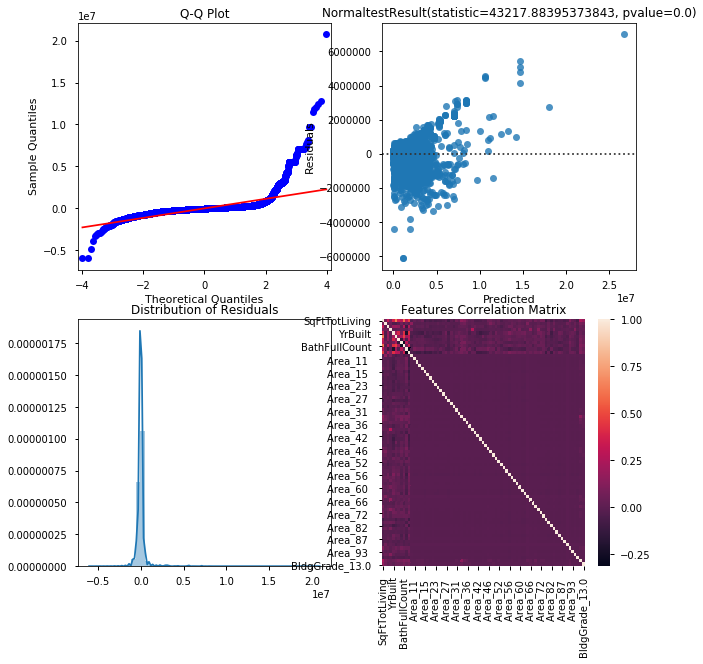

In [113]:
model(["SqFtLot", "YrBuilt", "Bedrooms", "BathHalfCount", "Bath3qtrCount", "BathFullCount", "SqFtTotBasement", "SqFtGarageAttached", ],
      ["Area", "InadequateParking", "BldgGrade", "SaleReason"])

## To Do
#### get rid of outliers replace with mean
#### drop colinearity features
#### make a better model
#### clean up graphs
#### comment code
#### answer these questions
    "How did you pick the question(s) that you did?"
    "Why are these questions important from a business perspective?"
    "How did you decide on the data cleaning options you performed?"
    "Why did you choose a given method or library?"
    "Why did you select those visualizations and what did you learn from each of them?"
    "Why did you pick those features as predictors?"
    "How would you interpret the results?"
    "How confident are you in the predictive quality of the results?"
    "What are some of the things that could cause the results to be wrong?"
#### Jupyter Notebook
#### PowerPoint
#### ReadMe
#### edit yml file